# ColorNet

## Importing Libraries

In [21]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Sequential, layers
from keras.api.layers import TextVectorization
from keras.api.utils import to_categorical

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
data = pd.read_csv("./data/colors.csv")
print(data.head())
print(data.shape)
print(data.describe())

             name  red  green  blue
0        parakeet  174    182    87
1    saddle brown   88     52     1
2  cucumber crush  222    237   215
3       pool blue  134    194   201
4        distance   98    110   130
(14157, 4)
                red         green          blue
count  14157.000000  14157.000000  14157.000000
mean     168.395211    155.798616    140.398531
std       67.551916     62.909409     64.894310
min        0.000000      0.000000      0.000000
25%      122.000000    108.000000     88.000000
50%      182.000000    164.000000    144.000000
75%      226.000000    211.000000    198.000000
max      255.000000    255.000000    255.000000


Let's check the distribution of name lengths

<Axes: ylabel='Frequency'>

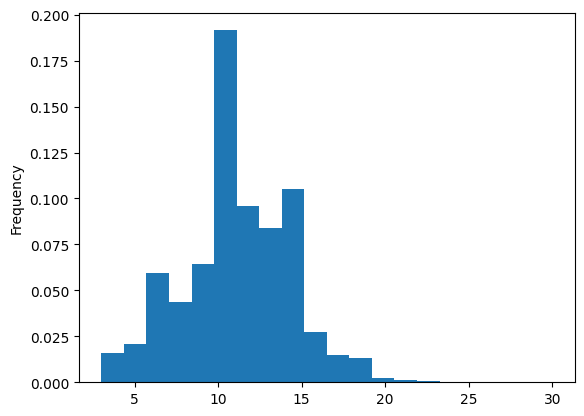

In [5]:
data["name"].map(len).plot(kind="hist", bins=20, density=True)

In [7]:
data[data["name"].map(len) > 25]
limited_data = data[data["name"].map(len) <= 25]

only 4 names have length greater than 25, and they are quite weird to be honest. We can ignore them.

In [8]:
limited_data["name"].map(len).sort_values()

9306      3
7452      3
2654      3
858       3
13961     3
         ..
10829    23
691      23
9494     24
13516    24
3741     25
Name: name, Length: 14153, dtype: int64

# Preprocess Data
We will tokenize the color names using keras text tokenization utility and pad the sequences to 25 len with zeroes.

In [9]:
max_len = 25
tv = TextVectorization(max_tokens=28, output_sequence_length=max_len, pad_to_max_tokens=True, split="character")
tv.adapt(limited_data["name"].values)
tokenized = tv(limited_data["name"].values)
print(limited_data["name"].values)
print(tokenized)

['parakeet' 'saddle brown' 'cucumber crush' ... 'aquatone' 'bottle green'
 'tandoori spice']
tf.Tensor(
[[16  3  4 ...  0  0  0]
 [11  3 14 ...  0  0  0]
 [12 13 12 ...  0  0  0]
 ...
 [ 3 26 13 ...  0  0  0]
 [19  9 10 ...  0  0  0]
 [10  3  7 ...  0  0  0]], shape=(14153, 25), dtype=int64)


2025-02-16 11:02:08.440230: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now that the names are numerical, we can perform one hot encoding on them.

In [10]:
one_hot_names = to_categorical(tokenized.numpy())
print(one_hot_names.shape)

(14153, 25, 28)


Now let's come to data normalization, the RGB values, must be between 0 and 1

In [11]:
def normalize(x) -> float:
    return x / 255.0


normalized_values = limited_data[["red", "green", "blue"]].apply(normalize)
normalized_values = np.column_stack([normalized_values["red"], normalized_values["green"], normalized_values["blue"]])
print(normalized_values)

[[0.68235294 0.71372549 0.34117647]
 [0.34509804 0.20392157 0.00392157]
 [0.87058824 0.92941176 0.84313725]
 ...
 [0.64705882 0.70588235 0.66666667]
 [0.03529412 0.21176471 0.14117647]
 [0.6745098  0.43921569 0.41960784]]


Now let's do the model making/training

In [12]:
model = Sequential()
model.add(layers.Input(shape=(max_len, 28)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(3, activation="sigmoid"))

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,147 (524.01 KB)

 Trainable params: 134,147 (524.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Training
history = model.fit(one_hot_names, normalized_values, epochs=40, batch_size=32, validation_split=0.1)

Epoch 1/40


2025-02-16 11:02:46.220055: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35663600 exceeds 10% of free system memory.


399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5891 - loss: 0.0650 - val_accuracy: 0.6391 - val_loss: 0.0611
Epoch 2/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6477 - loss: 0.0583 - val_accuracy: 0.6631 - val_loss: 0.0587
Epoch 3/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6688 - loss: 0.0564 - val_accuracy: 0.6674 - val_loss: 0.0569
Epoch 4/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6706 - loss: 0.0535 - val_accuracy: 0.6850 - val_loss: 0.0548
Epoch 5/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6714 - loss: 0.0519 - val_accuracy: 0.6935 - val_loss: 0.0545
Epoch 6/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6803 - loss: 0.0515 - val_accuracy: 0.6864 - val_loss: 0.0531
Epoch 7/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6892 - loss: 0.0492 - val_accuracy: 0.6596 - val_loss: 0.0514
Epoch 8/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6661 - loss: 0.0477 - val_accurac

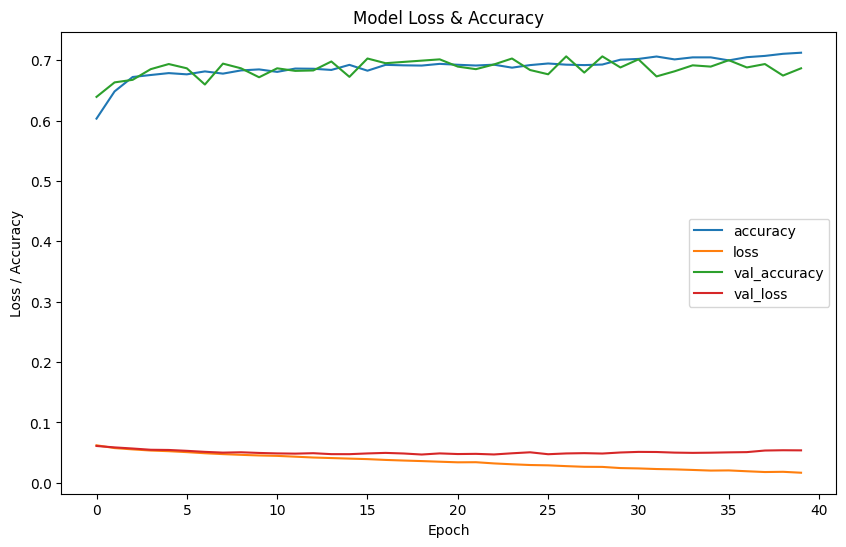

In [17]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10, 6), title="Model Loss & Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss / Accuracy")
plt.legend()
plt.show()

In [18]:
# Save
model.save("colornet.keras")
model.save_weights("colornet.weights.h5")

### Some prediction game!

In [23]:
# Global vars for the 3x3 plot
plot_idx = 0
fig = None
axes: np.ndarray | None = None


def plot_rgb(name: str, rgb: np.ndarray) -> None:
    global plot_idx, fig, axes

    if plot_idx % 9 == 0:
        if fig is not None:
            plt.show()
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))

    row = (plot_idx % 9) // 3
    col = (plot_idx % 9) % 3
    data = [[rgb]]
    if axes is not None:
        axes[row, col].imshow(data, interpolation="nearest")
        axes[row, col].axis("off")
        axes[row, col].set_title(name)

    plot_idx += 1

    if plot_idx % 9 == 0:
        plt.tight_layout(h_pad=0.5, w_pad=0.5)
        plt.show()


def scale(x: float) -> int:
    return int(x * 255)


def predict(color: str) -> None:
    name = color.lower()
    tokenized = tv([name])
    one_hot = to_categorical(tokenized.numpy(), num_classes=28)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(f"{color}: R,G,B: {r},{g},{b}")
    plot_rgb(f"{color} ({r},{g},{b})", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
white: R,G,B: 237,231,223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
forest: R,G,B: 92,99,89
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
sky: R,G,B: 201,213,206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
cerulean: R,G,B: 15,108,179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
crimson: R,G,B: 151,16,37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
turquoise: R,G,B: 61,171,181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
spring green: R,G,B: 127,188,114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
autumn red: R,G,B: 165,78,72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
summer blue: R,G,B: 124,179,197


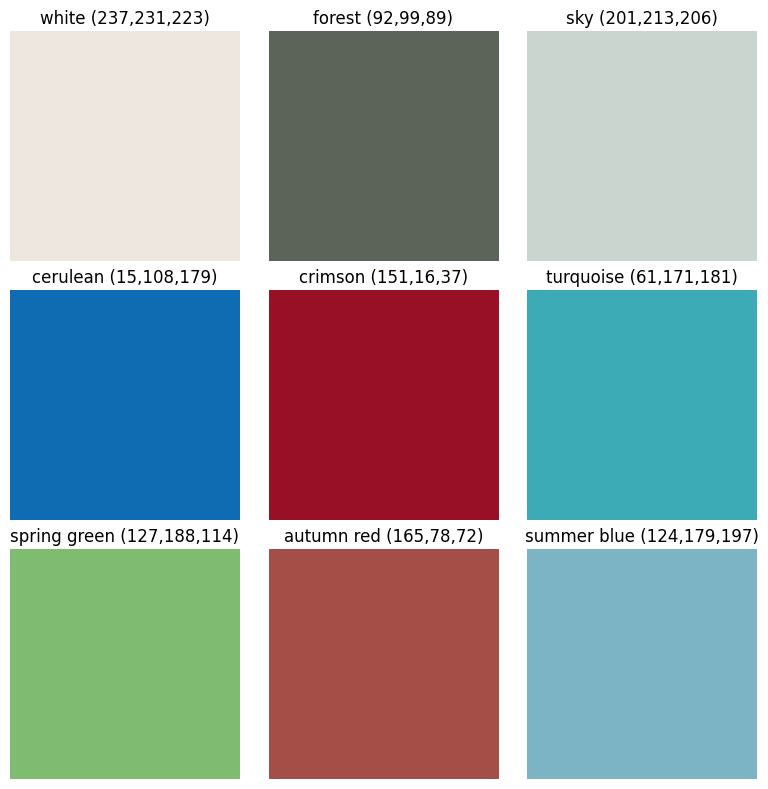

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
winter white: R,G,B: 235,233,224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ocean blue: R,G,B: 60,123,161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
desert sand: R,G,B: 204,192,172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
mountain grey: R,G,B: 163,150,136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
jungle green: R,G,B: 42,90,81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
meadow green: R,G,B: 194,204,190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
sunset orange: R,G,B: 233,125,124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
dawn pink: R,G,B: 238,160,183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
dusk purple: R,G,B: 122,90,146


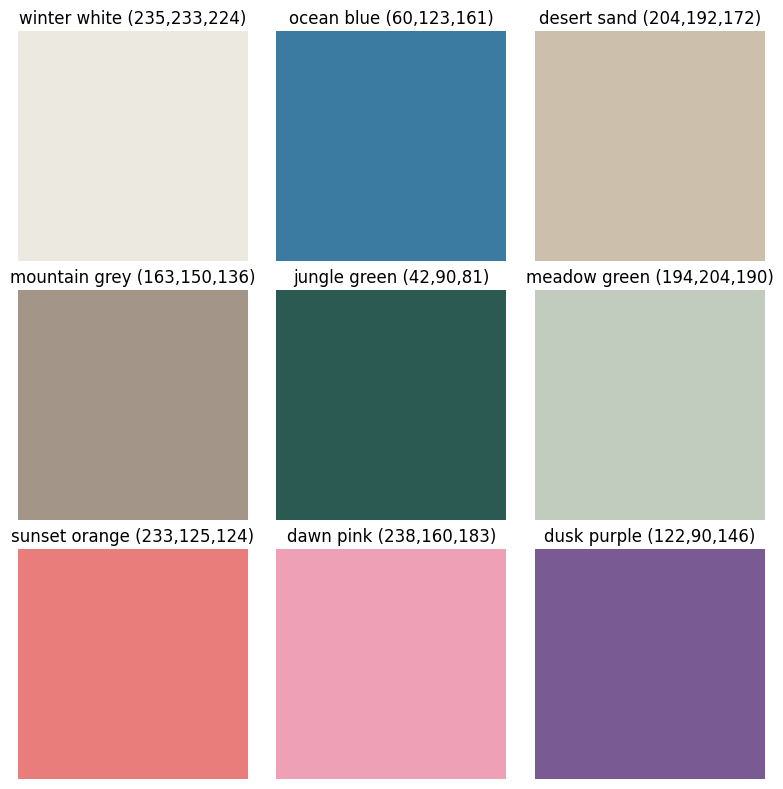

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
cloud grey: R,G,B: 107,150,116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
storm grey: R,G,B: 162,153,142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
moss green: R,G,B: 96,153,74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
coral reef: R,G,B: 209,164,126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
arctic white: R,G,B: 238,232,220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
volcanic red: R,G,B: 125,75,59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
tropical green: R,G,B: 133,172,131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
prairie gold: R,G,B: 222,200,183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
black: R,G,B: 39,36,45


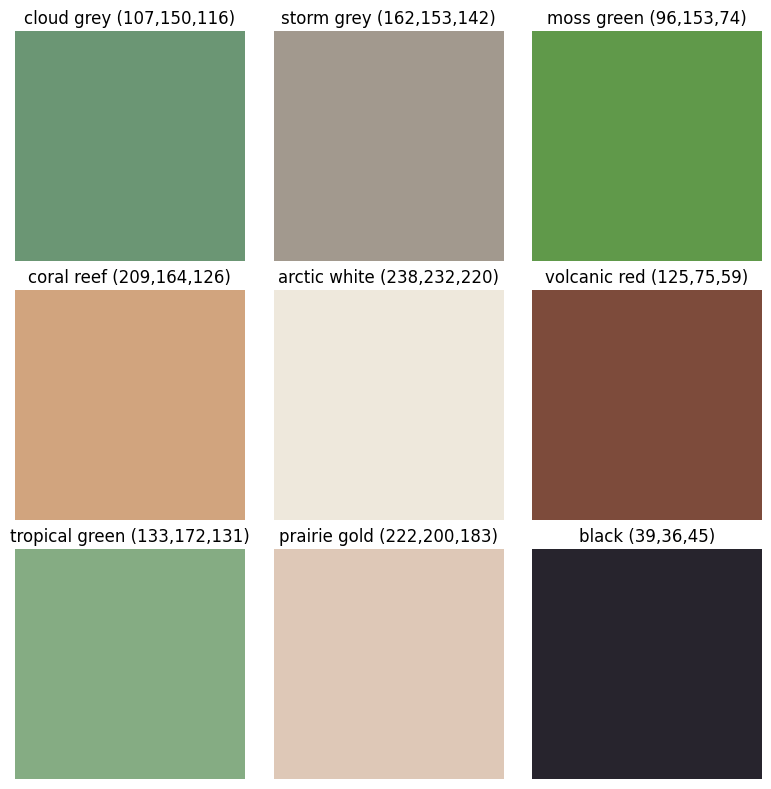

In [24]:
predict("white")
predict("forest")
predict("sky")
predict("cerulean")
predict("crimson")
predict("turquoise")
predict("spring green")
predict("autumn red")
predict("summer blue")
predict("winter white")
predict("ocean blue")
predict("desert sand")
predict("mountain grey")
predict("jungle green")
predict("meadow green")
predict("sunset orange")
predict("dawn pink")
predict("dusk purple")
predict("cloud grey")
predict("storm grey")
predict("moss green")
predict("coral reef")
predict("arctic white")
predict("volcanic red")
predict("tropical green")
predict("prairie gold")
predict("black")